# Taxi Demand Prediction- New York City 2018 TLC Data Analysis

Sun 23-May-2021 by Caihao Cui 

“If you torture the data long enough, it will confess — Ronald Coase”

<img src="https://raw.githubusercontent.com/cuicaihao/aws_nyc_taxi_analysis/master/reports/NYC_Area.jpg" alt="NYC_Area_Feature_Area"/> 
NYC Zones with IDs from the Google Earch. The Manhattan areas is highlighted in lite pink color.m

## Table of Content

1. [Bussiness Case / Real World Probelm](#1)
2. [Data Exploration and Analytics](#2)
    - 2.1 [Dataset](#2.1)
    - 2.2 [Create SqliteDB](#2.2)
    - 2.3 [Read and View the Taxi Zone by Shapefile](#2.3)
    - 2.4 [Data Analytics](#2.4)
3.[Case Study Objectives & Constraints](#3) 
    - 3.1 [Data ETL Operations](#3.1)
    - 3.2 [Load Taxi Zone Lookup Table](#3.2)
    - 3.3 [Feature Engineering](#3.3)
4.[Machine Learning Modelling: Demand Prediction](#4)
    - 4.1 [Predict Taxi Demand based on Time Only](#4.1)
    - 4.2 [Model Training GBDT (CatBoost)](#4.2)
    - 4.3 [Create Dummy API](#4.3)
    - 4.4 [Model Selection with AutoGluon](#4.4)
    - 4.5 [Tread Modelling with Prophet](#4.5)    
5.[Review and Discussion](#5)
6.[Reference List](#6)
7.[END](#)

In [1]:
# show project file structure:
# !tree ../ -L 2

## 1. Bussiness Case / Real World Probelm <a class="anchor" id="1"></a>

ABC company is a ride hailing company, they have large volume of subscribe users using their mobile app to get transportation services from local drivers. The mobile app for passengers and drivers will upload activities data to server for data analyst. ABC company wants to leverage AI/Machine Learning technologies to improve their business. 

**One of their key requirements is demand forecast.** They prefer to split a city into different grid, and forecast the demand in each grid at **5min, 15min and 30min** slot. If the demand goes high in future, ABC company will increase the price in that grid to slow down the demands.

ABC company would like to leverage AWS’ technology to implement the solution. However, they would like to see a proof-of-concept before the real project.

Imagine that you are a machine learning specialist from AWS, and you are required to demonstrate the potential result to ABC. Your team decided to leverage the New York City Taxi and Limousine Commission (TLC) Trip Record Data from AWS public datasets as source data (https://registry.opendata.aws/nyc-tlc-trip-records-pds/).

### POC: Data and Demo Case Requirments

- Data: After analysis of the huge data, you decided to use only the data after **Y2018 (Jan to June) and Manhattan as the demo area**. 
- Task: **You will design a stream of simulated input, and forecast 5min/15min/30min’s demands.**

**Note:** since the data is huge, you could just use yellow taxi part to do the work. And if you are not familiar with GIS systems, you could just use a description of grid (suggest 0.5 Mile * 0.5 Mile) to illustrate your result. 

**The key is the selection of models and algorithms, please explain why you would like to implement in that way. Moreover, you could discuss, not implement, some potential models and compare them.**

The following figure show the TLC Taxi Zones of the Manhattan and highlight two selection zones:
- Upper East Side North / Manhattan / Yellow Zone: <font color='#ff66ff'> LocationID = 236</font>
- Upper East Side South / Manhattan / Yellow Zone: <font color='#00ff00'> LocationID = 237</font>

 


<table><tr>
<td> <img src="https://raw.githubusercontent.com/cuicaihao/aws_nyc_taxi_analysis/master/reports/taxi_zone_map_manhattan.jpg" alt="taxi_zone_map_manhattan" width="500"/> </td>
<td> 
<img src="https://raw.githubusercontent.com/cuicaihao/aws_nyc_taxi_analysis/master/reports/NYC_Manhattan.jpg" alt="NYC_Manhattan" width="400"/>
 </td>
<td> 
<img src="https://raw.githubusercontent.com/cuicaihao/aws_nyc_taxi_analysis/master/reports/Manhattan_Upper_East_Side.jpg" alt="Manhattan_Upper_East_Side" width="400"/>
 </td>
</tr></table>





## 2. Data Exploration and Analytics <a class="anchor" id="2"></a>

The following libraries are the basic libraries for data analytics.

**Install the packages** 

In [2]:
# # check the python packages
!pip install pyshp -q
!pip install holidays -q
!pip install autogluon -q
!pip install catboost -q
!pip install tqdm -q
!pip install ipywidgets -q
!pip install prophet -q
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math

On the other hand, to visualize the information extracted from data, the libraries in below are also needed. For example, the Python Shapefile Library (pyshp) provides read and write support for the ESRI Shapefile format.

In [4]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Furthermore, to deal with the large scale of data (4GB for 6 months in this case), a database is needed. Here I will use SQLAlchemy, which is a Python SQL toolkit and Object Relational Mapper that gives application developers the full power and flexibility of SQL.

In [5]:
from sqlalchemy import create_engine
nyc_datebase_url = './nyc_database_2018a.db'
nyc_database = create_engine('sqlite:///nyc_database_2018a.db')

## 2.1 Dataset <a class="anchor" id="2.1"></a>
The information and download links of NYC Taxi Data can be found in the link below.Here we use Python code to download “Yellow” label data from 2018 January to 2018 June.
Link: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml. 

### Download the 2018 TLC Yellow Taxi CSV Data set

In [6]:
# Download the Trip Record Data
from pathlib import Path
def download_data(file_name, url, destination):
    if not Path(destination).is_dir(): # check destination folder 
        Path(destination).mkdir(parents=True, exist_ok=True)
    url_file = url + file_name
    raw_file_path = Path(destination).joinpath(file_name)
    if raw_file_path.is_file(): # check if file already downloaded
        print(f"{raw_file_path} exists.")
    else:
        print(f"{raw_file_path} downloading from {url_file}.")
        urllib.request.urlretrieve( url_file, str(raw_file_path))
        
    if raw_file_path.suffix == '.zip': # unzip files 
        with zipfile.ZipFile(str(raw_file_path),"r") as zip_ref:
            zip_ref.extractall(destination)
    return str(raw_file_path)
    
url_nyc_data = "https://s3.amazonaws.com/nyc-tlc/trip+data/"
raw_data_dir = "../data/raw/"
nyc_data_filepaths= []
for month in range(1,7):
    month_data_csv_name= f"yellow_tripdata_2018-{month:0=2d}.csv"
    nyc_data_file = download_data(month_data_csv_name, url_nyc_data, raw_data_dir) 
    nyc_data_filepaths.append(nyc_data_file)
print(f"Trip Record Raw Data is Ready! {nyc_data_filepaths}")

../data/raw/yellow_tripdata_2018-01.csv exists.
../data/raw/yellow_tripdata_2018-02.csv exists.
../data/raw/yellow_tripdata_2018-03.csv exists.
../data/raw/yellow_tripdata_2018-04.csv exists.
../data/raw/yellow_tripdata_2018-05.csv exists.
../data/raw/yellow_tripdata_2018-06.csv exists.
Trip Record Raw Data is Ready! ['../data/raw/yellow_tripdata_2018-01.csv', '../data/raw/yellow_tripdata_2018-02.csv', '../data/raw/yellow_tripdata_2018-03.csv', '../data/raw/yellow_tripdata_2018-04.csv', '../data/raw/yellow_tripdata_2018-05.csv', '../data/raw/yellow_tripdata_2018-06.csv']


### Download the Taxi Zone data and Lookup Table

In [7]:
# https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip
taxi_zone_zip_name= "taxi_zones.zip"
url_taxi_zone = "https://s3.amazonaws.com/nyc-tlc/misc/"
raw_shape_data_dir = "../data/raw/shape/"
download_data(taxi_zone_zip_name, url_taxi_zone, raw_shape_data_dir) 
print(f"Taxi Zone Raw Data is Ready! {raw_shape_data_dir}")


../data/raw/shape/taxi_zones.zip exists.
Taxi Zone Raw Data is Ready! ../data/raw/shape/


In [8]:
# https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv
taxi_zone_lookup_csv_name = "taxi+_zone_lookup.csv"
nyc_zone_lookup_filepath = download_data(taxi_zone_lookup_csv_name, url_taxi_zone, raw_data_dir) 

../data/raw/taxi+_zone_lookup.csv exists.


In [9]:
# # extra download
# # taxi_zone_map_manhattan.jpg
# taxi_zone_map_manhattan_jpg="taxi_zone_map_manhattan.jpg"
# url_taxi_zone_map = "https://www1.nyc.gov/assets/tlc/images/content/pages/about/"
# download_data(taxi_zone_map_manhattan_jpg, url_taxi_zone_map, raw_data_dir) 
# # data_dictionary_trip_records_yellow.pdf
# download_data("data_dictionary_trip_records_yellow.pdf", \
#               "https://www1.nyc.gov/assets/tlc/downloads/pdf/", \
#               "../references")

### A. Trip Record Data
The yellow taxi trip records include fields capturing

- pick-up and drop-off dates/times
- pick-up and drop-off locations
- trip distances
- itemized fares
- rate types
- payment types
- driver-reported passenger counts
and the explanations are in this dictionary (https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).


In [10]:
# quick view the dataset
df_nyc_data = pd.read_csv(nyc_data_filepaths[0], nrows=10)
df_nyc_data.head().T

,0,1,2,3,4
VendorID,1,1,1,1,1
tpep_pickup_datetime,2018-01-01 00:21:05,2018-01-01 00:44:55,2018-01-01 00:08:26,2018-01-01 00:20:22,2018-01-01 00:09:18
tpep_dropoff_datetime,2018-01-01 00:24:23,2018-01-01 01:03:05,2018-01-01 00:14:21,2018-01-01 00:52:51,2018-01-01 00:27:06
passenger_count,1,1,2,1,2
trip_distance,0.5,2.7,0.8,10.2,2.5
RatecodeID,1,1,1,1,1
store_and_fwd_flag,N,N,N,N,N
PULocationID,41,239,262,140,246
DOLocationID,24,140,141,257,239
payment_type,2,2,1,2,1


## 2.2 Create SqliteDB <a class="anchor" id="2.2"></a>

In [11]:
def isSqlite3Db(db):
    if not Path(db).exists(): return False
    else: 
        db_size = Path(db).stat().st_size/1000**3 # disk drive manufacturers use 1000,  because it made their disk drive look bigger 
        print(f"File size is about {db_size} GB")
        if db_size > 6.0:
            return True
        else:
            print("Warning: database exists ")
            return False

In [12]:
%%time
from tqdm.notebook import tqdm
if not isSqlite3Db(nyc_datebase_url):
    j, chunksize = 1, 100000
    for fp in tqdm(nyc_data_filepaths, desc='Main loop' ):
        fp_reader = pd.read_csv(fp, chunksize=chunksize, iterator=True)
        for df in tqdm(fp_reader, desc=f'Loading: {Path(fp).stem}' ):
            df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns}) # check columns name        
            df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']] # get pickup hour
            df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']] # get dropoff hour
            df.index += j
            df.to_sql('table_record', nyc_database, if_exists='append')
            j = df.index[-1] + 1
    del df

File size is about 7.631192064 GB
CPU times: user 31.6 ms, sys: 4.6 ms, total: 36.2 ms
Wall time: 35.6 ms


## 2.3 Read and View the Taxi Zone by Shapefile <a class="anchor" id="2.3"></a>

In [13]:
sf = shapefile.Reader("../data/raw/shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,1.023971e+06,266866.032718
259,260,0.133514,0.000422,Woodside,260,Queens,1.010063e+06,211298.529136
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,9.807446e+05,197628.272456
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,9.994435e+05,222247.381595


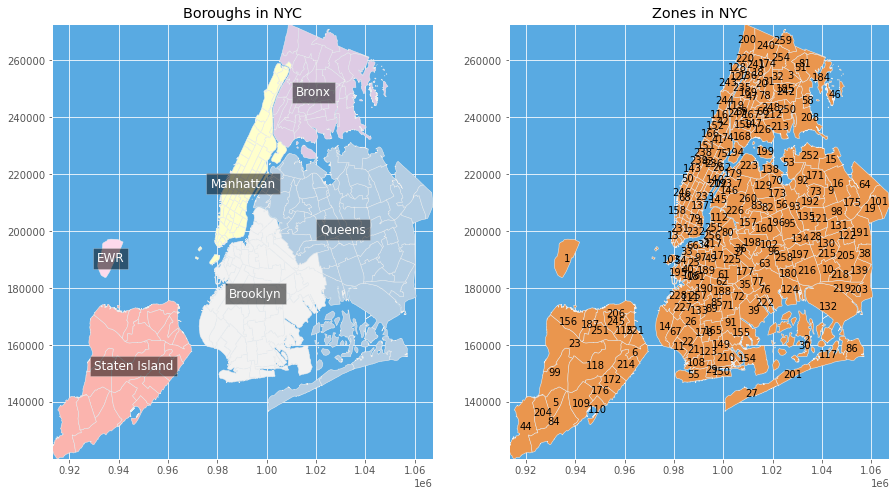

In [14]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin
    return lat_min, lat_max, lon_min, lon_max

def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

## 2.4 Data Analytics <a class="anchor" id="2.4"></a>

###  Q1: Which regions have most pickups and drop-offs?
In the beginning, we select the data we need (location of pickup/dropoff ans their counts) from the databse.

In [15]:
if not 'nyc_database' in globals(): # check connection
    nyc_datebase_url = './nyc_database_2018a.db'
    nyc_database = create_engine('sqlite:///nyc_database_2018a.db')

df_pu = pd.read_sql_query('SELECT PULocationID AS LocationID, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY PULocationID', nyc_database)
df_do = pd.read_sql_query('SELECT DOLocationID AS LocationID, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY DOLocationID', nyc_database)

In [16]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])

df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), \
                                    how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                    .sort_values(by=['LocationID'])

df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")

# Top 3 pick zones
PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
PUtop3 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(3)

# Top 3 drop-off zones
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))
DOtop3 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(3)

In the tables below, we can see that in the first half of 2018,

- Top 3 pickup zones are Upper East Side South, Midtown Center and  Upper East Side North which are all in Manhattan.
- Top 3 drop-off zones are also Upper East Side South, Midtown Center, and Upper East Side North.

In [17]:
PUtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
237,2231822.0,1954564.0,4186386.0,Upper East Side South,Manhattan
161,2103461.0,2051106.0,4154567.0,Midtown Center,Manhattan
236,2040795.0,2110900.0,4151695.0,Upper East Side North,Manhattan


In [18]:
DOtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
236,2040795.0,2110900.0,4151695.0,Upper East Side North,Manhattan
161,2103461.0,2051106.0,4154567.0,Midtown Center,Manhattan
237,2231822.0,1954564.0,4186386.0,Upper East Side South,Manhattan


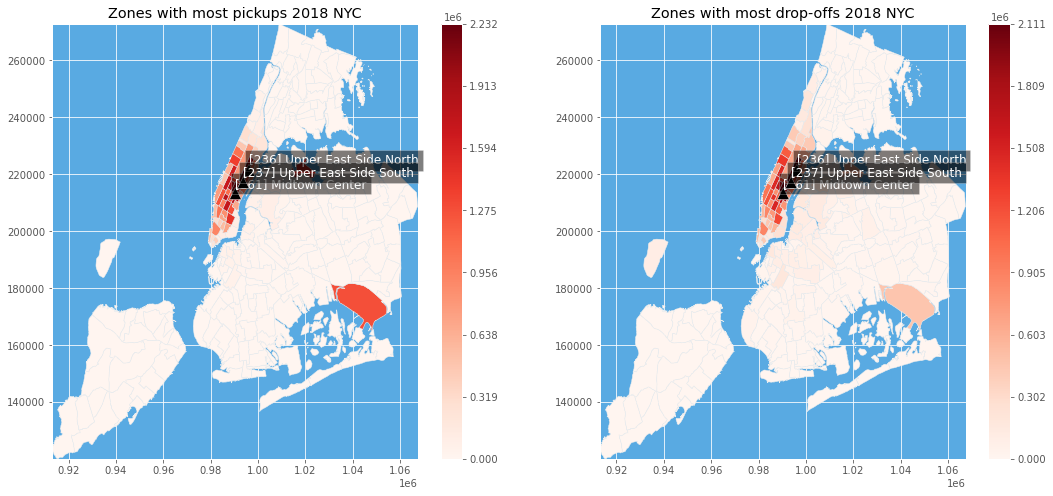

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups 2018 NYC")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs 2018 NYC")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop3.index.tolist())

Note that in the figure above, we can see that despite the top 3 pickup/dropoff zones, many other zones in **Manhattan** are also popular. 

By the way, the zone in the lower-right part of the map, which is **JFK Airport**, is the most popular pickup/dropoff zone in New York City excluding zones in Manhattan.

Next, we investigate boroughs with most pickups and drop-offs. In the tables below, we can see that **Manhattan** is obviously the most popular borough and Staten Island is the least popular borough. 

Queens and Brooklyn are also popular, although their pickup/droppoff count is less than 10% of Manhattan’s.

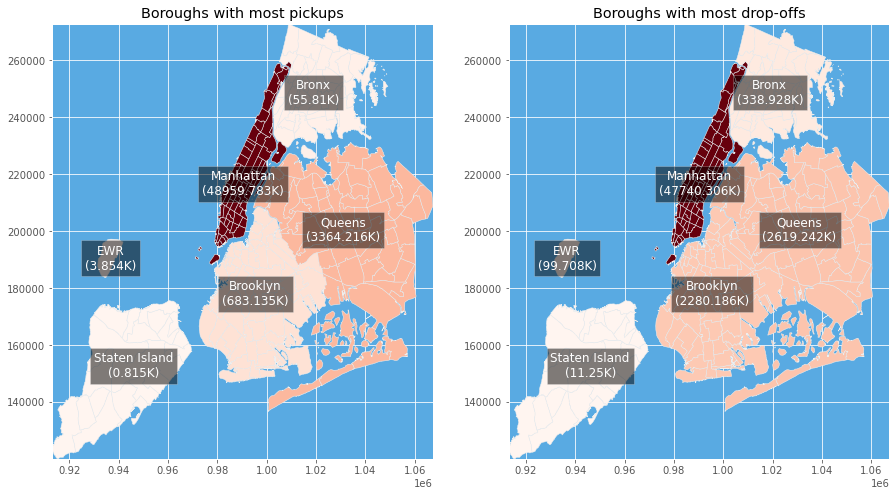

In [20]:
df_q1_region = df_q1.groupby(["borough"], as_index=False) \
                    .agg({'PUcount': 'sum', 'DOcount': 'sum', 'TOTALcount': 'sum'}) \
                    .sort_values(by=['TOTALcount'], ascending=False)
PUcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['PUcount'].tolist()))
DOcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['DOcount'].tolist()))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, sf, heat = PUcount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, sf, heat = DOcount)

### Q2: When are the peak hours and off-peak hours for taking taxi?
Again we start from selecting data needed from the database.

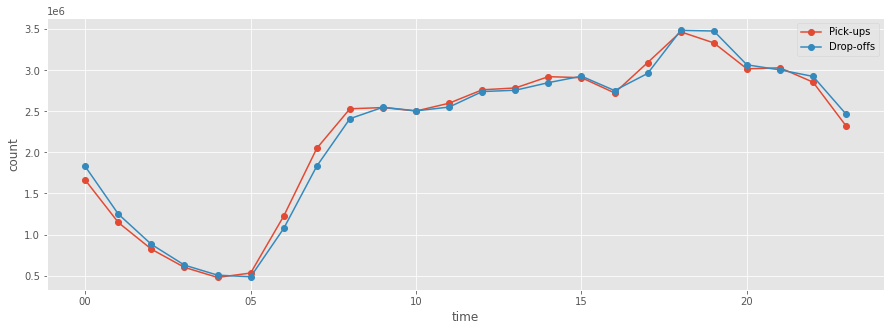

In [21]:
df_pu = pd.read_sql_query('SELECT pickup_hour AS time, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY pickup_hour', nyc_database)
df_do = pd.read_sql_query('SELECT dropoff_hour AS time, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY dropoff_hour', nyc_database)
df_q2 = df_pu.merge(df_do, on="time")

template = pd.DataFrame(["{0:0=2d}".format(x) for x in range(0,24)], columns=["time"])
df_q2 = df_q2.join(template.set_index("time"), how = 'outer', on=["time"]).fillna(0) \
                .groupby(["time"], as_index=False) \
                .agg({'PUcount': 'sum', 'DOcount': 'sum'}) \
                .rename(columns = {'PUcount':'Pick-ups', 'DOcount': 'Drop-offs'}) \
                .sort_values(by='time')

ax = df_q2.plot(x='time', y=['Pick-ups', 'Drop-offs'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
plt.show()

As you can see, according to the NYC Taxi records from 2018 January to 2018 June, it is found that
- The peak hours are around 6PM ~ 7PM.
- The off-peak hours are around 5AM.

### Q3: What are the differences between short and long distance trips of taking taxi?
#### 1. Define short and long distance
To get a closer look at the distribution of trip distance, we select the trip_distance column values and print out its summary statistics.

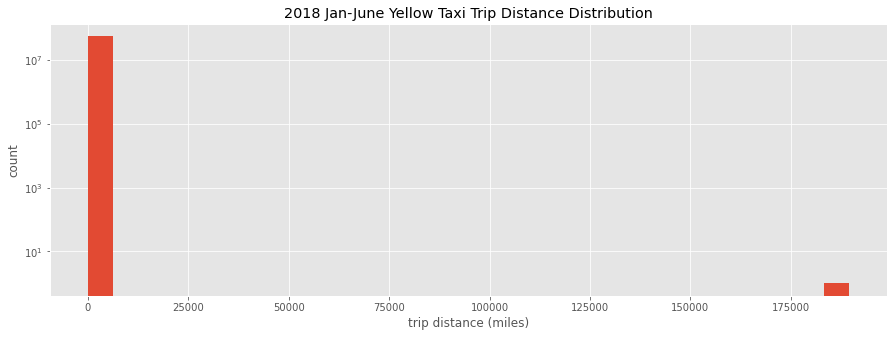

In [22]:
df_dist = pd.read_sql_query('SELECT trip_distance FROM table_record', nyc_database)
ax = df_dist['trip_distance'].hist(bins=30, figsize=(15,5))
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
ax.set_title("2018 Jan-June Yellow Taxi Trip Distance Distribution")
plt.show()

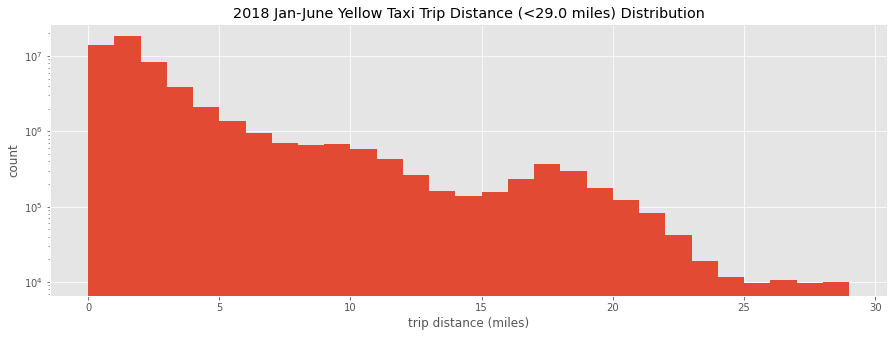

In [23]:
dist_most = df_dist['trip_distance'].quantile(.9995)
df_dist_clean = df_dist[df_dist['trip_distance'] <= dist_most] # without outliers
ax = df_dist_clean['trip_distance'].hist(bins= int(dist_most), figsize=(15,5))
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
ax.set_title(f"2018 Jan-June Yellow Taxi Trip Distance (<{ dist_most} miles) Distribution")
plt.show()

According to the dustribution of trip distances and the fact that it takes about 30 miles to drive across the whole New York City, we decided to use 30 as the number to split the trips into short or long distance trips.

In [24]:
df_q3_short = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                 WHERE trip_distance < 30', nyc_database)
df_q3_long = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                WHERE trip_distance >= 30 ', nyc_database)
print("Short Trips: {} records in total.\nLong Trips: {} records in total."\
     .format(df_q3_short.values[0][0], df_q3_long.values[0][0]))

Short Trips: 53903852 records in total.
Long Trips: 21883 records in total.


#### 2. Observe The Difference in Temporal Attributes
Instinctly, we think that the pickup/dropoff time may be different for short trips and long trips since the purpose for short trips is not the same as that of long trips.
To validate our assumption, we first select temporal information from our database.

Afterwards, we visualize the pickup/dropoff counts at each time for both short trips and long trips.

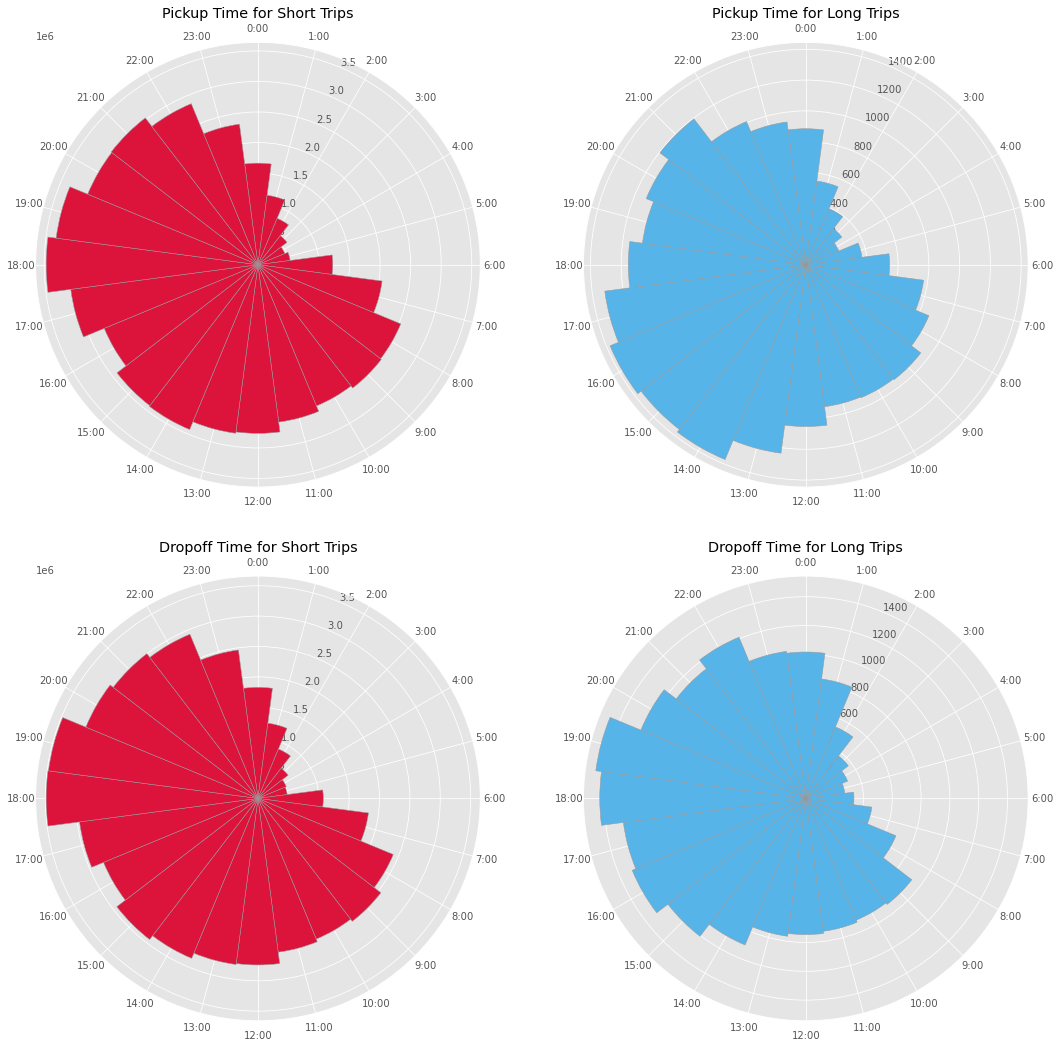

In [25]:
df_q3_short = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 30 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)
df_q3_long = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 30 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)

df_q3 = df_q3_short.merge(df_q3_long, on=["PUtime", "DOtime"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips", \
                                        "PUtime":"pickup time", "DOtime":"dropoff time"})

df_q3_PU = df_q3.groupby(["pickup time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="pickup time")
df_q3_DO = df_q3.groupby(["dropoff time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="dropoff time")

def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

def diff_short_long_trip_on_time():
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    ax = plt.subplot(2,2,1, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['short trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,2, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['long trips'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    ax = plt.subplot(2,2,3, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['short trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,4, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['long trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

diff_short_long_trip_on_time()

Based on the figure shown above, we can observe that

1. For short trips,
- the peak hours of pickups are from 6PM to 10PM.
- the peak hours of dropoffs are also from 6PM to 10PM.

2. For long trips ( > 30 miles),
- the peak hours of pickups are  1PM to 5PM.
- the peak hours of dropoffs are from 6PM to 10PM.

3. The off-peak hours are similar for both short trips and long trips.

With these observations, it can be guesed that

- Short trips are mainly contributed by people having dinner and hanging out at night.
- Long trips ( > 30 miles) are contributed by travelers taking an arrival or a departure.

#### 3. Observe The Difference in Spatial Attributes
So let’s examine if our guesses are correct by summarize the spatial attributes of short trips and long trips.

Here we extract pickup/dropoff locations and their counts from database by grouping the counts by each ('pickup zone', 'dropoff zone') pair.

After extracting data from database, we then arrange the information and show the top 3 ('pickup zone', 'dropoff zone') pair for both short trips and long trips.

In [26]:
df_q3_short = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 30 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)
df_q3_long = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 30 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)

df_q3 = df_q3_short.merge(df_q3_long, on=["PULocationID", "DOLocationID"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips"})
df_q3 = df_q3.merge(df_loc[["LocationID", "zone"]], left_on="PULocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"pickup zone"}) \
             .merge(df_loc[["LocationID", "zone"]], left_on="DOLocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"dropoff zone"})

In the tables below, we can see that

1. The top 3 routes for short trips are all in the most prosperous area in Manhattan, which are filled with restaurants and entertainment venues.

2. The top 3 routes for long trips ( > 30 miles) are routes that drive from one airport zone to another.
- The second popular route is a special case that passengers are picked up from and also dropped-off at JFK Airport, which may be some kind of city tours of the tranfer during their waiting time between the connecting flights.

These findings support our guesses that long trips are for traveling and that short trips are for eating and entertaining.

In [27]:
ShortTrip_top3 = df_q3.sort_values(by="short trips", ascending=False).head(3)
ShortTrip_top3[['pickup zone', 'dropoff zone', 'short trips']]

,pickup zone,dropoff zone,short trips
803,Upper East Side North,Upper East Side North,276809
813,Upper East Side South,Upper East Side South,249833
207,Upper East Side South,Midtown East,139087


In [28]:
LongTrip_top3 = df_q3.sort_values(by="long trips", ascending=False).head(3)
LongTrip_top3[['pickup zone', 'dropoff zone', 'long trips']]

,pickup zone,dropoff zone,long trips
24,JFK Airport,Newark Airport,1473
112,JFK Airport,JFK Airport,683
26,LaGuardia Airport,Newark Airport,487


On the other hand, we can also observe the popular zones for short and long trips on map. By aggregating the pickup/dropoff trip count of each zone, we then show the popular pickup/drop-off zones for short trips and long trips.

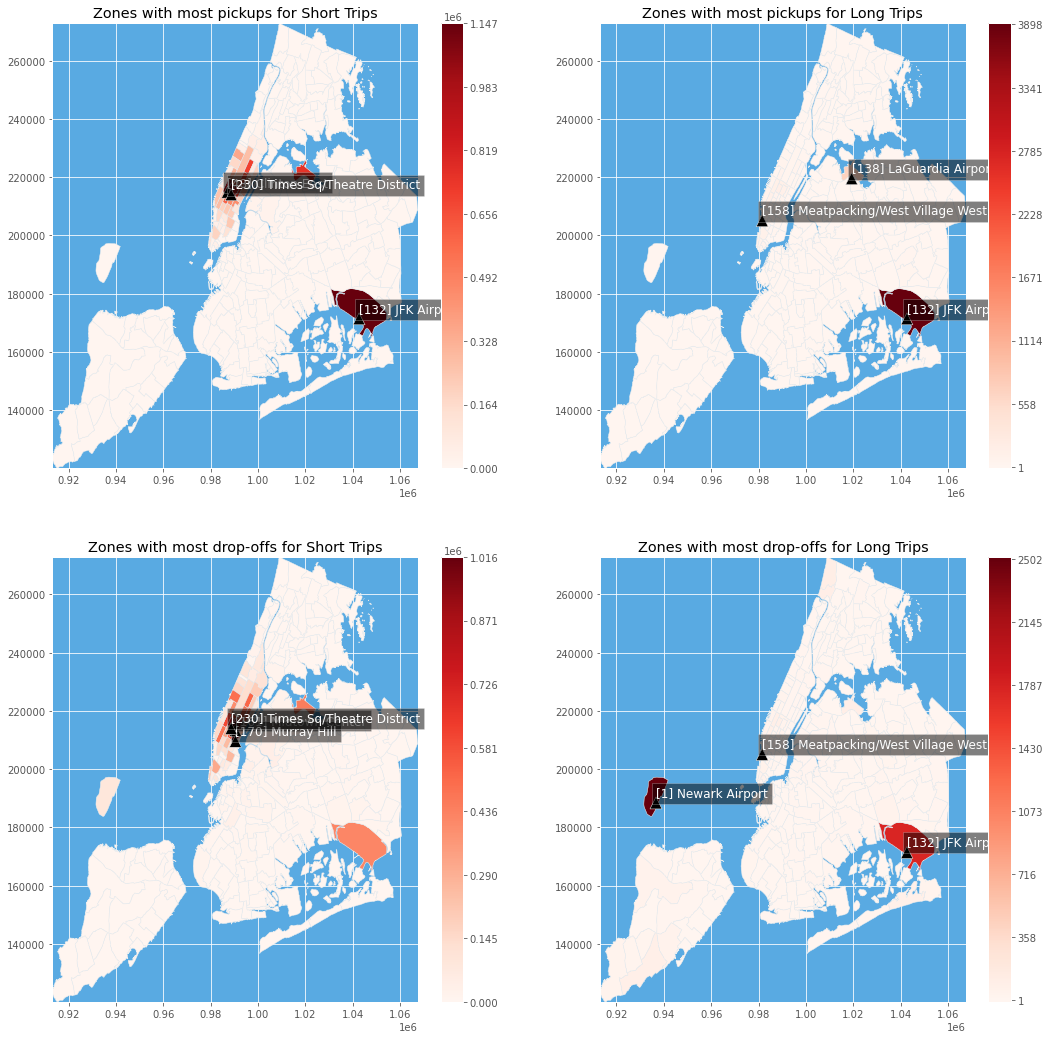

In [29]:
df_q3_PU = df_q3.groupby("PULocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
PUtop3_short = df_q3_PU.sort_values(by=['short trips'], ascending=False).set_index("PULocationID").head(3)
PUtop3_long = df_q3_PU.sort_values(by=['long trips'], ascending=False).set_index("PULocationID").head(3)
PUcount_short = dict(zip(df_q3_PU['PULocationID'].tolist(), df_q3_PU['short trips'].tolist()))
PUcount_long = dict(zip(df_q3_PU['PULocationID'].tolist(), df_q3_PU['long trips'].tolist()))

df_q3_DO = df_q3.groupby("DOLocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
DOtop3_short = df_q3_DO.sort_values(by=['short trips'], ascending=False).set_index("DOLocationID").head(3)
DOtop3_long = df_q3_DO.sort_values(by=['long trips'], ascending=False).set_index("DOLocationID").head(3)
DOcount_short = dict(zip(df_q3_DO['DOLocationID'].tolist(), df_q3_DO['short trips'].tolist()))
DOcount_long = dict(zip(df_q3_DO['DOLocationID'].tolist(), df_q3_DO['long trips'].tolist()))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, sf, heat=PUcount_short, text=PUtop3_short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, sf, heat=PUcount_long, text=PUtop3_long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, sf, heat=DOcount_short, text=DOtop3_short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, sf, heat=DOcount_long, text=DOtop3_long.index.tolist())

From the figure above, we can find something interesting:

1. Surprisingly, **JFK Airport** is the most popular pickup zone for short trips.
- More specifically, in 6 months there are about 1 million taxis taken from **JFK Airport** (about 5700 trips per day) and drive no more than 30 miles to arrive their destination.
- These passengers may contain foreign travelers or locals who just came back from abroad.
2. There are more drop-offs at **JFK Airport** than **Newark Airport** in short trips.
3. There are more drop-offs at **Newark Airport** than **JFK Airport** in long trips.
4. For long trips, JFK Airport and LaGuardia Airport are the most popular pickup zones.

#### 4. Other Differences
Lastly, compare short trips and long trips in some other aspects.

In [30]:
def diff_short_long_trip_on(attr, rpr="count", kind='bar'):
    df_q3_short = pd.read_sql_query('SELECT '+attr+', count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance < 30 \
                                    GROUP BY '+attr, nyc_database)
    df_q3_long = pd.read_sql_query('SELECT '+attr+', avg(trip_distance) AS AVG_trip_distance, count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance >= 30 \
                                    GROUP BY '+attr, nyc_database)
    if rpr == "proportion":
        s = np.sum(df_q3_short['count'].values)
        df_q3_short['proportion'] = [float(x)/s for x in df_q3_short['count']]
        s = np.sum(df_q3_long['count'].values)
        df_q3_long['proportion'] = [float(x)/s for x in df_q3_long['count']]
    
    df_q3 = df_q3_short.merge(df_q3_long, on=attr, suffixes=["_short", "_long"]) \
                        .rename(columns={rpr+"_short":"short trips", rpr+"_long":"long trips"}) 
    ax = df_q3.plot(x=attr, y=['short trips', 'long trips'], kind=kind, figsize=(15,5))
    ax.set_ylabel(rpr)
    ax.set_title(attr.replace("_", " ")+" difference in short/long trip")


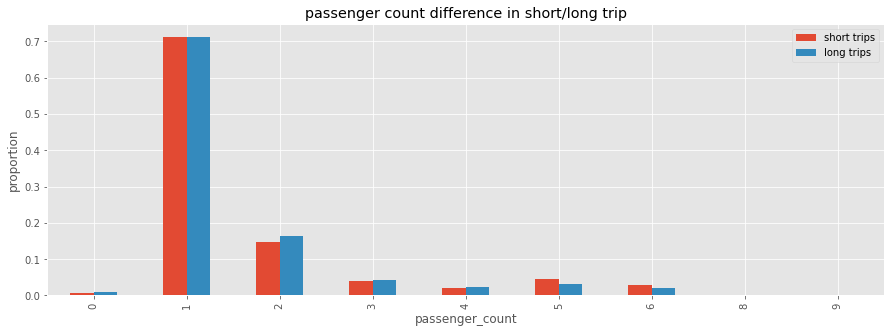

In [31]:
diff_short_long_trip_on("passenger_count", rpr="proportion", kind='bar')

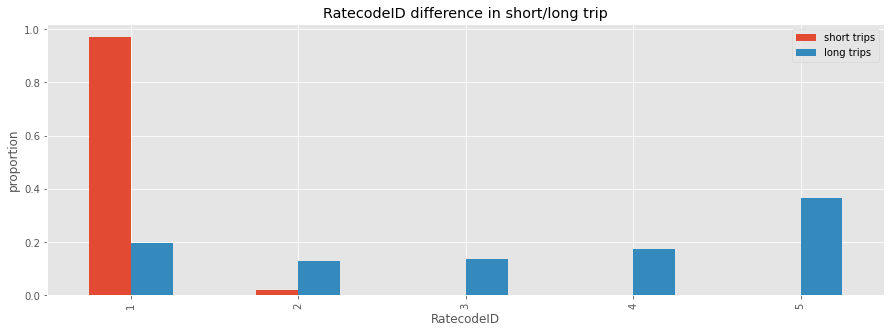

In [32]:
diff_short_long_trip_on("RatecodeID", rpr="proportion", kind='bar')

RateCodeID represents the final rate code in effect at the end of the trip:

- 1=Standard rate
- 2=JFK
- 3=Newark
- 4=Nassau or Westchester
- 5=Negotiated fare
- 6=Group ride

It can be seen that 40 percent of long trips use Negotiated fare and another 40 percent of long trips use JFK, Newark, or Nassau or Westchester while less than 5 percent of short trips use any of them.

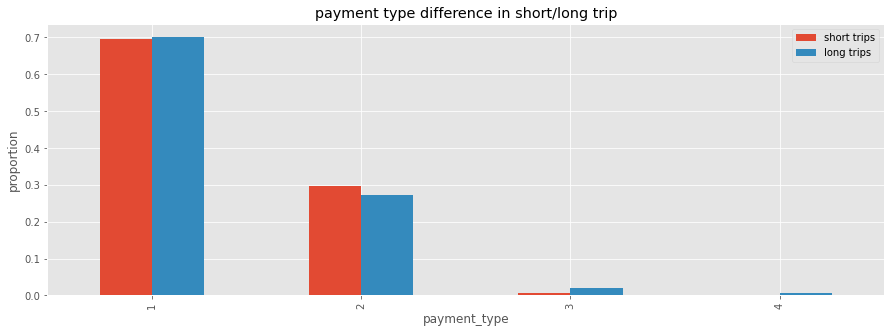

In [33]:
diff_short_long_trip_on("payment_type", rpr="proportion", kind='bar')

payment_type is a numeric code signifying how the passenger paid for the trip:

- 1=Credit card
- 2=Cash
- 3=No charge
- 4=Dispute

Passengers of long trips paid a little more frequent in credit card and a little less frequent in cash comparing to that of short trips.

## 3. Case Study Objectives & Constraints <a class="anchor" id="3"></a>

Our objective is to predict the number of pickups as accurately as possible for each region in a 5min, 10min, 15min intervals. We will break up the whole New York City into regions.

The following data are downloaded to local drive.

### 3.1 Data ETL Operations <a class="anchor" id="3.1"></a>
1. Load the data set and only keep the key features.
2. Select a region based on the LocationID. 
3. Select the time range to remove wrong records.

To make a demand prediction, the first step is to keep the data and model as simple as possible but not simpler. Thus, onlye the pickup time and region ID are considered in the following steps. 

In [34]:
cache_file_path = "../data/interim/nyc_data.csv"


DEBUG = True # debug mode will load just one csv file, for example: yellow_tripdata_2018-01.csv
CACHE = False # save the cache file if you like to rerun the modelling section only without new data as input.


if CACHE:
    df_nyc_data = pd.read_csv(cache_file_path)
else:
    if DEBUG:
        nyc_data_filepaths= [ f"../data/raw/yellow_tripdata_2018-{month:0=2d}.csv" for month in range(1,7)]
        print(f"Debug: loading {nyc_data_filepaths[0]}")
        df_nyc_data = pd.read_csv(nyc_data_filepaths[0]) # pick Jan as sample        
        header_list = ["tpep_pickup_datetime", "PULocationID"] # Use pickup time and location only as demand / reduce RAM cost 
        df_nyc_data = df_nyc_data[header_list]
    else:
        nyc_database = create_engine('sqlite:///nyc_database_2018a.db')    
        df_nyc_data = pd.read_sql_query('SELECT tpep_pickup_datetime, PULocationID FROM table_record', nyc_database)# save cache
if not CACHE:
    df_nyc_data.to_csv(cache_file_path,index=False)
    print("save the cache file as {cache_file_path}")    
print(f"Debug Mode: {DEBUG} Done.")
print(df_nyc_data.info())

Debug: loading ../data/raw/yellow_tripdata_2018-01.csv
save the cache file as {cache_file_path}
Debug Mode: True Done.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759874 entries, 0 to 8759873
Data columns (total 2 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   tpep_pickup_datetime  object
 1   PULocationID          int64 
dtypes: int64(1), object(1)
memory usage: 133.7+ MB
None


In [35]:
df_nyc_data.tail(3)

,tpep_pickup_datetime,PULocationID
8759871,2018-01-31 23:28:00,74
8759872,2018-01-31 23:24:40,7
8759873,2018-01-31 23:28:16,7


### 3.2 Load Taxi Zone Lookup Table <a class="anchor" id="3.2"></a>

The locations are xxLocationID from the data source, thus load the taxi zone lookup table to get the details of the zone informations.

In [36]:
nyc_zone_lookup_filepath = "../data/raw/taxi+_zone_lookup.csv"
df_zone = pd.read_csv(nyc_zone_lookup_filepath)
df_zone.sort_values(by="LocationID",inplace=True)
df_zone.tail(3) 

,LocationID,Borough,Zone,service_zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN
264,265,Unknown,NaN,NaN


Because we are focusing on the borough of **Manhattan**. We will get the region location id list.

In [37]:
df_LocationID_Manhatan = df_zone.loc[df_zone["Borough"]=="Manhattan"]
LocationID_Manhatan = df_LocationID_Manhatan["LocationID"].values
print(f"LocationID List in Manhatan {len(LocationID_Manhatan)} IDs in total :\n {LocationID_Manhatan}")

LocationID List in Manhatan 69 IDs in total :
 [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]


We can adjust the selection of the regions for modelling, to speed up this notebook, I picked just the following 2 locations:
- Upper East Side North / Manhattan / Yellow Zone: LocationID = 236
- Upper East Side South / Manhattan / Yellow Zone: LocationID = 237
> Note: if we can model two areas, we can scale the process up to model more(>2) ares in theory. For POC, this is a good early practice.

In [38]:
Selected_Location_ID = [236,237]
# or
# Selected_Location_ID = LocationID_Manhatan # selecet all the zone in Manhatan. 
df_nyc_data_Manhatan = df_nyc_data.loc[(df_nyc_data['PULocationID'].isin(Selected_Location_ID))]
print(f"Original Sample Number: {df_nyc_data.shape[0]:>10}")
print(f"Selected Sample Number: {df_nyc_data_Manhatan.shape[0]:>10}")
# del df_nyc_data # Delete the nyc data if you want to save RAM, but do the pd.DataFrame.copy().

Original Sample Number:    8759874
Selected Sample Number:     706680


In [39]:
df_LocationID_Manhatan.loc[df_LocationID_Manhatan['LocationID'].isin(Selected_Location_ID)]

,LocationID,Borough,Zone,service_zone
235,236,Manhattan,Upper East Side North,Yellow Zone
236,237,Manhattan,Upper East Side South,Yellow Zone


### 3.3 Featire Engineering <a class="anchor" id="3.3"></a>

A quick look of the data table, we know the time (Y-M-D hh:mm:ss) and location IDs of of the taxi pickup records. 

In [40]:
df_nyc_data_Manhatan = df_nyc_data_Manhatan.reset_index(drop=True) 
df_nyc_data_Manhatan.tail()

,tpep_pickup_datetime,PULocationID
706675,2018-01-31 23:23:13,237
706676,2018-01-31 23:52:05,237
706677,2018-01-31 23:37:46,237
706678,2018-01-31 23:11:22,236
706679,2018-01-31 23:03:27,237


#### Data Cleaning
As you know, the data set we used only contain taxi records from 2018-Jan to 2018-June.
We can extract each part of the time as an indpendent feature, such as year, month, day (of the month), hour, minute, second, day of the week, week of the year, etc. 


In [41]:
df = df_nyc_data_Manhatan.copy()
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df["demand"] = 1 # each record is 1 demand.
df["year"] = df.tpep_pickup_datetime.dt.year.astype(np.uint16) 
df["month"] = df.tpep_pickup_datetime.dt.month.astype(np.uint8)
df["day"] = df.tpep_pickup_datetime.dt.day.astype(np.uint8) 
df["hour"] = df.tpep_pickup_datetime.dt.hour.astype(np.uint8) 
df["minute"] = df.tpep_pickup_datetime.dt.minute.astype(np.uint8) 
df["second"] = df.tpep_pickup_datetime.dt.second.astype(np.uint8) 
df["weekday"] = df.tpep_pickup_datetime.dt.weekday.astype(np.uint8) # 0-6
df['week_of_year']= df.tpep_pickup_datetime.dt.isocalendar().week
df["PULocationID"] = df["PULocationID"].astype(np.uint16)
df.tail(3)

,tpep_pickup_datetime,PULocationID,demand,year,month,day,hour,minute,second,weekday,week_of_year
706677,2018-01-31 23:37:46,237,1,2018,1,31,23,37,46,2,5
706678,2018-01-31 23:11:22,236,1,2018,1,31,23,11,22,2,5
706679,2018-01-31 23:03:27,237,1,2018,1,31,23,3,27,2,5


Now we can filter out the records does not belong here (2018-01 to 2018-06).

In [42]:
if DEBUG:
    mask = (df["year"]==2018) & (df['month'] <= 1)
else:
    mask = (df["year"]==2018) & (df['month'] <= 6)
df_clean = df.loc[mask,:].copy()
df_clean = df_clean.reset_index(drop=True) 
print(f"original data records number :{df.shape[0]:>10}")
print(f"afterward data records number:{df_clean.shape[0]:>10}")
print(f"filtered data records number :{df.shape[0] - df_clean.shape[0]:>10}")

original data records number :    706680
afterward data records number:    706660
filtered data records number :        20


In [43]:
df_clean.tail(3)

,tpep_pickup_datetime,PULocationID,demand,year,month,day,hour,minute,second,weekday,week_of_year
706657,2018-01-31 23:37:46,237,1,2018,1,31,23,37,46,2,5
706658,2018-01-31 23:11:22,236,1,2018,1,31,23,11,22,2,5
706659,2018-01-31 23:03:27,237,1,2018,1,31,23,3,27,2,5


#### Feature Selection
Based on the rule of keeping the data as simple as possible, we will drop the following features base on the information it contribute to the demand in common sense. As you can see all the features are categorical features.

Removed feature:
- year: all same value 2018, it is not helpful for modelling.
Optional:
- month {1, 2, 3, 4, ,5 ,6} but {7, ... , 12} are not in the dataset.
- week of year {1, 2, ... } but somewhere {, 53, 54 } are not in the dataset.

> The above two feature are all descrete values, they can be used as categorical features to represent difference granularities of the time.  In this practice, they are not used due to missing fully records in the dateset.



In [44]:
def get_region_datase(df_in, locatioinID, freq='5min'):
    
    df_out = df_in.loc[df_in['PULocationID']==locatioinID]
    df_out = df_in.groupby(pd.Grouper(key='tpep_pickup_datetime', freq=freq)).agg({
                                            "demand": "sum"
                                        }) # group the demand in 5mins slot
#     df_out['month'] = df_out.index.month
    df_out['day'] = df_out.index.day # day of the month 
    df_out['hour'] = df_out.index.hour 
    df_out['min'] = df_out.index.minute
    df_out['weekday']= df_out.index.weekday 
#     df_out['week_of_year']= df_out.index.isocalendar().week
    # df_out['day_name'] = df_out.index.day_name().tolist()
    # df_out.info()
    data_type_list= {
    "demand"    : np.float32,
#     "month"     : np.uint8,
    "day"       : np.uint8,
    "hour"      :np.uint8,
    "min"       :np.uint8,
    "weekday"       :np.uint8,
#     "week_of_year": np.uint8,
    }
    df_out = df_out.astype(data_type_list).copy()
    return df_out.copy()

# get the data set key: locationi_id, value: pd.dataframe
df_set = {}
for location_id in Selected_Location_ID:
    df_set[location_id] = get_region_datase(df_clean, location_id)

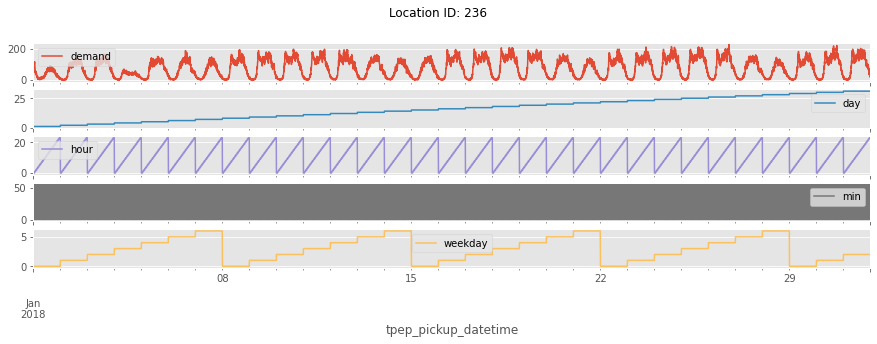

236                       demand  day  hour  min  weekday
tpep_pickup_datetime                                 
2018-01-31 23:55:00     20.0   31    23   55        2 (8928, 5)


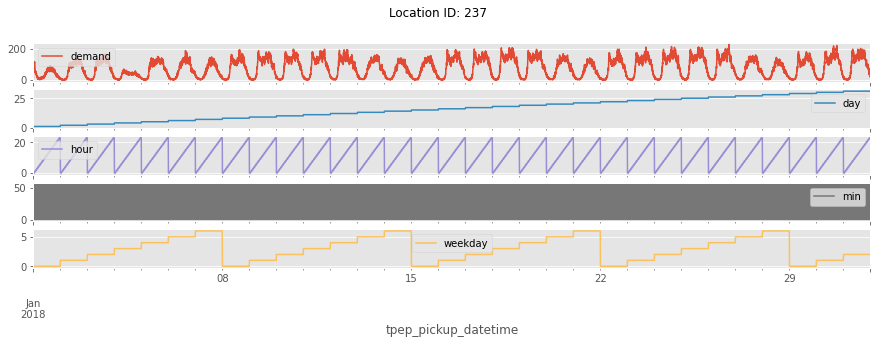

237                       demand  day  hour  min  weekday
tpep_pickup_datetime                                 
2018-01-31 23:55:00     20.0   31    23   55        2 (8928, 5)


In [45]:
# review the data 
for location_id in Selected_Location_ID:
    df_one = df_set[location_id]
    df_one.plot(subplots=True, layout=(6,1), figsize=(15, 5), title = f"Location ID: {location_id}")
    plt.show()
    print(location_id,df_one.tail(1), df_one.shape)

Now, we have the data in pre-processsed mode. The following section will focusing on the modelling side. 

## 4 Machine Learning Modelling: Demand Prediction <a class="anchor" id="4"></a>

**Task**: forecast 5min/15min/30min’s demands.

**Basic Assumption**:

### 4.1 Predict Taxi Demand based on the Time Only <a class="anchor" id="4.1"></a>

First, get the training data and test data ready for LocationID 236 as example. 

Consider we all feature are categorical, we will try Gradient Boost Decision Tree (GBDT) model by `catboost`.

#### Get the training, validation and test data input/output pairs. 

In [46]:
from sklearn.model_selection import train_test_split

def data_split(df_full):
    # split data into 2 parts: train (75%), test*(25%) : simple approach now (cross validation is a better option)
    split_point = int(df_full.shape[0]*.75) 
    train_df = df_full.iloc[:split_point]
    test_df =  df_full.iloc[split_point:]
    assert df_full.shape[0] == train_df.shape[0]+test_df.shape[0] # check the number
    return train_df, test_df

def create_datapair(train_df, test_df):
    # get development data
    X = train_df.drop('demand', axis=1)
    y = train_df.demand
    categorical_features_indices = np.where(X.dtypes != float)[0]

    # get the train and validation data
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=1234)

    # get the test data
    X_test = test_df.drop('demand', axis=1)
    y_test = test_df.demand
    return X_train, X_validation, y_train, y_validation, X_test, y_test, categorical_features_indices

In [47]:
# pick a id
location_id = 236
# get the data set
df_full =  df_set[location_id]
train_df, test_df = data_split(df_full)
X_train, X_validation, y_train, y_validation, X_test, y_test, categorical_features_indices = create_datapair(train_df, test_df)



### 4.2 Model training by GDBT (CatBoost Model) <a class="anchor" id="4.2"></a>

#### Training the model with MAE loss


In [48]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_absolute_error 

In [49]:
def train_model(X_train, y_train, X_validation, y_validation, categorical_features_indices, location_id, default_dir ="./"):
    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices )
    val_pool = Pool( X_validation, y_validation, cat_features=categorical_features_indices )
    train_dir = default_dir + str(location_id) + '_model_catboot/'
    model = CatBoostRegressor(
        random_seed=1234,
        logging_level='Silent',
        iterations = 2000,
        learning_rate = 0.1,
        loss_function = 'MAE',
        depth=4,
        train_dir = train_dir
    )
    model.fit(
        train_pool,
        eval_set = val_pool, # use t validation
        # logging_level='Verbose',  # you can uncomment this for text output
        # plot=True, # you can show figure in progress.
        use_best_model = True,
        early_stopping_rounds = 100 
    )
    print(f"Model Done {location_id}")
    model_dir = train_dir+"model"
    model.save_model(model_dir)
    return model, model_dir

model, model_dir = train_model(X_train, y_train, X_validation, y_validation, categorical_features_indices, location_id)

Model Done 236


We can save/register the model and model path for later prediction.

In [50]:
model_file = {}
model_path = {}

model_file[location_id] = model
model_path[location_id] = model_dir

In [51]:
model_file, model_path

({236: <catboost.core.CatBoostRegressor at 0x7fc3e62e4d50>},
 {236: './236_model_catboot/model'})

In [52]:
def predict(model, X, y):
    y_pred = model.predict(X)
    y_np = y.to_numpy().flatten() # convert the pd.DataFrame to numpy.Array
    df_results =  pd.DataFrame({'target': y_np,'y_pred': y_pred}, index=y.index) 
    err_mae = mean_absolute_error(y_np, y_pred)
    return df_results, err_mae

Review the training results.

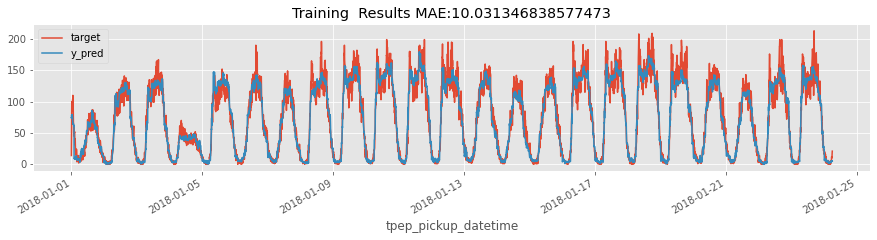

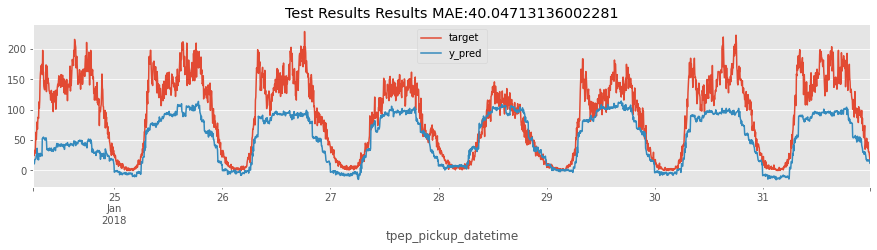

In [53]:
df_results_train , err_mae_train  = predict(model, X_train, y_train)
df_results_train .head(10000).plot(figsize=(15,3),  subplots=False, grid =True,\
                                       title= f"Training  Results MAE:{err_mae_train }")
plt.show()

df_results_test, err_mae_test = predict(model, X_test, y_test)
df_results_test.head(10000).plot(figsize=(15,3),  subplots=False, grid =True, \
                                       title= f"Test Results Results MAE:{err_mae_test}")
plt.show()

You can reload the saved model for prediction with the following code. 

In [54]:
# reload the model and make predicton.
from_file = CatBoostRegressor()
from_file.load_model(model_dir)
y_pred = from_file.predict(X_test)
y_np = y_test.to_numpy().flatten()
print(f"MAE : {mean_absolute_error(y_np, y_pred)}");

MAE : 40.04713136002281


#### Ranking the Feature by Importances

We can also ranking the feature via the importance score from the model by the training pool.

,scores
features,
hour,72.929755
day,20.153852
weekday,5.802847
min,1.113546


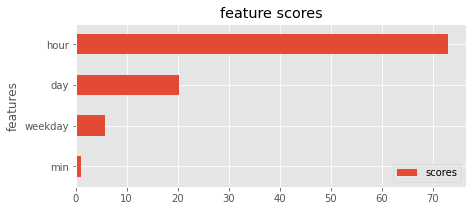

In [55]:
feature_names = X_train.columns
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices )
def get_feature_importances(model, feature_names):
    feature_importances = model.get_feature_importance(train_pool)
    depth = str(model.get_params()['depth'])
#     scores_name = 'scores_d' + depth
    scores_name = 'scores'
    df_feature_score = pd.DataFrame({'features': feature_names,  scores_name:feature_importances})
    df_feature_score = df_feature_score.set_index('features')
    df_sorted = df_feature_score.sort_values(by=scores_name, ascending=False)
    return df_sorted

# show scores
df_sorted = get_feature_importances(model, feature_names)
ax = df_sorted.plot.barh(y = "scores" , figsize = (7,3), title =  'feature scores')
ax.invert_yaxis()
df_sorted

#### Build one Regional Model
The following code will built another model like the one we did for the ID237

Model Done 237


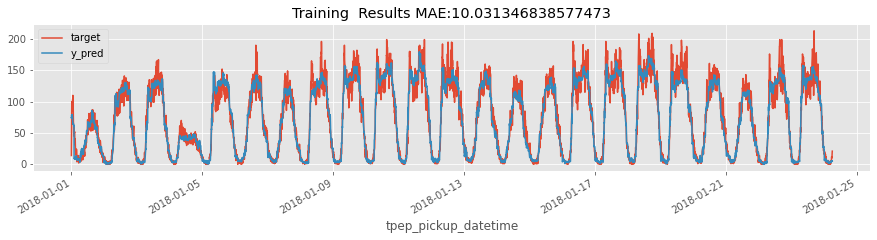

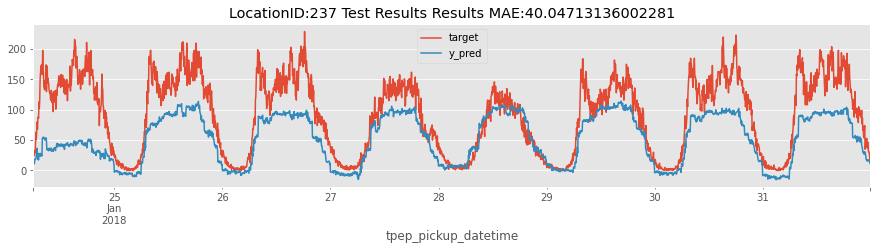

In [56]:
# 1. Pick a id
location_id = 237

# 2. Get the data set
df_full =  df_set[location_id]
train_df, test_df = data_split(df_full)
X_train, X_validation, y_train, y_validation, X_test, y_test, categorical_features_indices = create_datapair(train_df, test_df)

# 3. Build the model
model, model_dir = train_model(X_train, y_train, X_validation, y_validation, categorical_features_indices, location_id)

# 4. Review the performance
##  train 
df_results_train , err_mae_train  = predict(model, X_train, y_train)
df_results_train .head(10000).plot(figsize=(15,3),  subplots=False, grid =True,\
                                       title= f"Training  Results MAE:{err_mae_train }")
plt.show()

## test
df_results_test, err_mae_test = predict(model, X_test, y_test)
df_results_test.head(10000).plot(figsize=(15,3),  subplots=False, grid =True, \
                                       title= f"LocationID:{location_id} Test Results Results MAE:{err_mae_test}")
plt.show()

In [57]:
model_file[location_id] = model
model_path[location_id] = model_dir
model_file, model_path

({236: <catboost.core.CatBoostRegressor at 0x7fc3e62e4d50>,
  237: <catboost.core.CatBoostRegressor at 0x7fc75bbba590>},
 {236: './236_model_catboot/model', 237: './237_model_catboot/model'})

Here, you can repeate the above process to create a region model for each LocationID. 

### 4.3 Create a Dummy API to get the currnet Taxi Demand <a class="anchor" id="4.3"></a>

We create a few dummy input to simulate the time.

In [58]:
from datetime import datetime
from dateutil.parser import parse
 
ts= pd.date_range(datetime(2018, 2, 1, hour=12, minute=0), periods=5, freq='5min').strftime("%Y-%m-%d %H:%M:%S").tolist()
for current_time_str in ts:
    now = parse(current_time_str)
#     x_in = [now.month, now.day, now.hour, now.minute, now.isocalendar()[1], now.isoweekday(), ]
    x_in = [now.day, now.hour, now.minute, now.isoweekday(), ]
    y_out = model.predict(x_in)
    print(f"{current_time_str} taxi demand is {y_out}")

2018-02-01 12:00:00 taxi demand is 57.24193837942571
2018-02-01 12:05:00 taxi demand is 56.27122545665672
2018-02-01 12:10:00 taxi demand is 63.41723531179596
2018-02-01 12:15:00 taxi demand is 57.83471046398826
2018-02-01 12:20:00 taxi demand is 57.06329116627465


We can also create a dummy API to tell the currnet demand of your localtime 

In [59]:
def current_taxi_demand(model):
    now = datetime.now()
#     print(current_time)
#     print(f"{now.year=}")
#     print(f"{now.month=}")
#     print(f"{now.day=}")
#     print(f"{now.hour=}")
#     print(f"{now.minute=}")
#     print(f"{now.second=}")
#     print(f"day of the week: {now.isoweekday()}")
#     print(f"week of the year: {now.isocalendar()[1]}")
    x_in = [now.day, now.hour, now.minute,  now.isoweekday(), ]
    y_out = model.predict(x_in)
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")
    print(f"{current_time} taxi demand is {y_out}")
    return y_out
 
# you get the resutls based on your local time 
current_taxi_demand(model)

2021-05-23 15:21:54 taxi demand is 67.16356174643354


67.16356174643354

 ### 4.4 Model Selection with AutoGluon <a class="anchor" id="4.4"></a>
 
 In order to improve the performance, we employ the AWS AutoGluon package to build the model. 
 
 All we need are the pands.DataFrame for training and test.
 

In [60]:
from autogluon.tabular import TabularPredictor

label='demand'
save_path = 'agModels-predictDemand'  # specifies folder to store trained models
predictor = TabularPredictor(label=label, path=save_path, problem_type="regression").fit(train_df)

Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictDemand/"
AutoGluon Version:  0.2.0
Train Data Rows:    6696
Train Data Columns: 4
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    34367.98 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 4 | ['day', 'hour', 'min', 'weekday']
	Types of features in processed data (raw dtype, special dtypes):
		('int', []) : 4 | ['day', 'hour', 'min',

[1000]	train_set's rmse: 10.2755	valid_set's rmse: 12.2855
[2000]	train_set's rmse: 9.37586	valid_set's rmse: 11.7523
[3000]	train_set's rmse: 8.97421	valid_set's rmse: 11.6007
[4000]	train_set's rmse: 8.68082	valid_set's rmse: 11.5281
[5000]	train_set's rmse: 8.47076	valid_set's rmse: 11.5253


	-11.5045	 = Validation root_mean_squared_error score
	3.69s	 = Training runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM ...
	-10.088	 = Validation root_mean_squared_error score
	0.49s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-10.4124	 = Validation root_mean_squared_error score
	0.61s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-10.128	 = Validation root_mean_squared_error score
	1.36s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-10.1151	 = Validation root_mean_squared_error score
	0.5s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-19.3207	 = Validation root_mean_squared_error score
	5.86s	 = Training runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-10.211	 = Validation root_mean_squared_error score
	0.66s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
		Unable to impo

In [61]:
y_test = test_df[label]  # values to predict
test_data_nolab = test_df.drop(columns=[label])  # delete label column to prove we're not cheating
test_data_nolab.head()

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,day,hour,min,weekday
tpep_pickup_datetime,,,,
2018-01-24 06:00:00,24,6,0,2
2018-01-24 06:05:00,24,6,5,2
2018-01-24 06:10:00,24,6,10,2
2018-01-24 06:15:00,24,6,15,2
2018-01-24 06:20:00,24,6,20,2


In [62]:
predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Evaluation: root_mean_squared_error on test data: -15.164023399353027
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -15.164023399353027,
    "mean_squared_error": -229.94760131835938,
    "mean_absolute_error": -10.523660659790039,
    "r2": 0.9402740612901883,
    "pearsonr": 0.973415664356942,
    "median_absolute_error": -6.684553146362305
}


Predictions:  
 tpep_pickup_datetime
2018-01-24 06:00:00    20.776222
2018-01-24 06:05:00    22.529154
2018-01-24 06:10:00    23.476639
2018-01-24 06:15:00    28.734505
2018-01-24 06:20:00    33.907959
                         ...    
2018-01-31 23:35:00    23.780645
2018-01-31 23:40:00    23.433002
2018-01-31 23:45:00    23.567402
2018-01-31 23:50:00    21.373096
2018-01-31 23:55:00    20.750713
Freq: 5T, Name: demand, Length: 2232, dtype: float32


/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


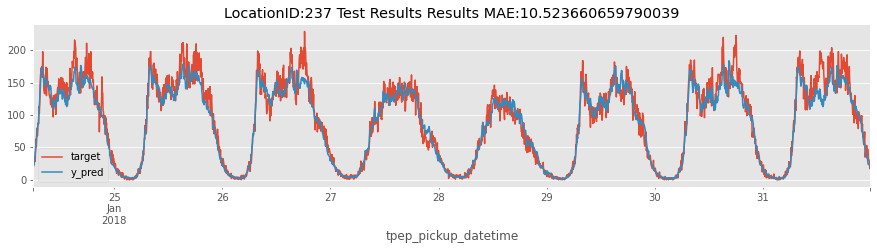

In [63]:
df_results_train =  pd.DataFrame({'target': y_test.to_numpy().flatten(),'y_pred': y_pred}, index=y_test.index) 
err_mae = mean_absolute_error(y_test, y_pred)
df_results_train.plot(figsize=(15,3),  subplots=False, grid =True, \
                      title=f"LocationID:{location_id} Test Results Results MAE:{err_mae}")
plt.show()

In [64]:
predictor.leaderboard(test_df, silent=True)

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,-15.081586,-10.127978,0.003240,0.001839,1.363904,0.003240,0.001839,1.363904,1,True,6
1,LightGBMLarge,-15.117768,-9.962612,0.016323,0.007039,0.498933,0.016323,0.007039,0.498933,1,True,10
2,WeightedEnsemble_L2,-15.164023,-9.726567,0.203964,0.122906,3.271425,0.003107,0.000604,0.421496,2,True,11
3,RandomForestMSE,-15.409185,-10.412409,0.144910,0.108434,0.613864,0.144910,0.108434,0.613864,1,True,5
4,ExtraTreesMSE,-15.603323,-10.115075,0.154587,0.105256,0.499103,0.154587,0.105256,0.499103,1,True,7
5,LightGBM,-15.875308,-10.088009,0.026707,0.008168,0.487989,0.026707,0.008168,0.487989,1,True,4
6,XGBoost,-15.940330,-10.210962,0.106721,0.003425,0.658513,0.106721,0.003425,0.658513,1,True,9
7,LightGBMXT,-18.478207,-11.504517,0.217651,0.080108,3.690194,0.217651,0.080108,3.690194,1,True,3
8,NeuralNetFastAI,-25.841331,-19.320700,0.040649,0.015120,5.864950,0.040649,0.015120,5.864950,1,True,8
9,KNeighborsDist,-29.365788,-20.851538,0.105162,0.105800,0.003455,0.105162,0.105800,0.003455,1,True,2


Base on the leaderboard, it looks like catboost is good model class for this demand forcasting task.

Create Dummy API function by AutoGluon package. 

In [65]:
for current_time_str in ts:
    now = parse(current_time_str)
    x_in = {'day': [now.day],  'hour':[now.hour], 'min':[now.minute], 'weekday':[now.isoweekday()]}
    df_xin = pd.DataFrame.from_dict(x_in)
    # autoGluon model input and output are pandas.DataFrames
    y_out = predictor.predict(df_xin)                              
    print(f"{current_time_str} taxi demand is {y_out.to_numpy()[0]}")

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2018-02-01 12:00:00 taxi demand is 64.7005615234375
2018-02-01 12:05:00 taxi demand is 63.679771423339844
2018-02-01 12:10:00 taxi demand is 68.25321960449219
2018-02-01 12:15:00 taxi demand is 69.92345428466797
2018-02-01 12:20:00 taxi demand is 70.35163116455078


**Summary**

- There are many machine learning model can be used to forcast the demand. 
- Model selection are based on the input dataset, feature relationship and model performance. 
- Region model set can be updated independently with plans.
- Small model are good candidates to adapt the local or regional patterns.



### 4.5 Trend Modelling with FB-Prophet Model and Holidays <a class="anchor" id="4.5"></a>

We can alos explore the Prophet models, which is designed for time series data modelling.  It has its own benefits like add holiday and sepcial event in the modelling. 

#### Create the standarn dataframe for Prohet model

The new data must has two columns 'ds' and 'y'.

In [66]:
df_new = pd.DataFrame()
df_new["ds"] = df_full.index.copy() 
df_new["y"] =  df_full['demand'].values
df_new.head()

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ds,y
0,2018-01-01 00:00:00,14.0
1,2018-01-01 00:05:00,46.0
2,2018-01-01 00:10:00,80.0
3,2018-01-01 00:15:00,87.0
4,2018-01-01 00:20:00,100.0


/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


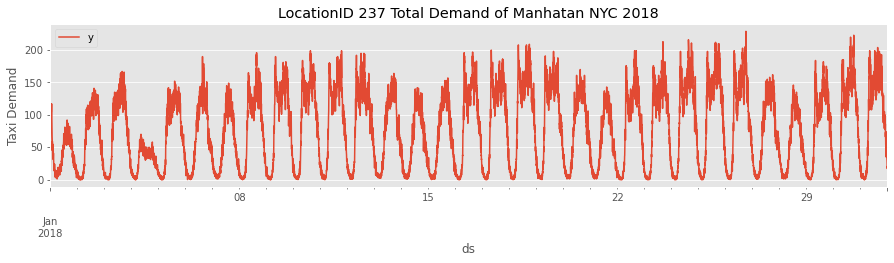

In [67]:
df_new.plot(x='ds', y = "y", figsize=(15, 3), grid = True, \
            title=f"LocationID {location_id} Total Demand of Manhatan NYC 2018", ylabel="Taxi Demand")
plt.show()

In [68]:
# we can review the data by 15 mins
# df_temp = df_new.groupby(pd.Grouper(key='ds', freq='15min')).agg({
#                                         "y": "sum"
#                                     })
# df_temp.plot(
#     y = "y", figsize=(15, 3), grid=True, title="Total Demand of Manhatan NYC 2018 Jan", ylabel="Taxi Demand")
# plt.show()
# del df_temp

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
import holidays
# add the public holiday and special events 
us_holidays_2018 = []
for date, name in holidays.US(years=2018).items():
    us_holidays_2018.append(str(date))
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(us_holidays_2018),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2018-02-05']),
  'lower_window': 0,
  'upper_window': 1,
})

# create a holidy table
holidays = pd.concat((playoffs, superbowls)).reset_index(drop=True)
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2018-01-01,0,1
1,playoff,2018-01-15,0,1
2,playoff,2018-02-19,0,1
3,playoff,2018-05-28,0,1
4,playoff,2018-07-04,0,1
5,playoff,2018-09-03,0,1
6,playoff,2018-10-08,0,1
7,playoff,2018-11-11,0,1
8,playoff,2018-11-12,0,1
9,playoff,2018-11-22,0,1


Now, let build a baisc model with holiday

In [70]:
# Python
from prophet import Prophet
m = Prophet(holidays=holidays, yearly_seasonality=False) # we do not have sufficent data to support yearly_seasonality
m.fit(df_new)

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
# Make prediction of the next week
future = m.make_future_dataframe(periods=12*24*7, freq='5min', include_history = True  ) # 7 days / 1 week ahead
forecast = m.predict(future)

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
forecast.tail()

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,superbowl,superbowl_lower,superbowl_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
10939,2018-02-07 23:35:00,89.022196,8.008642,92.090373,63.133007,118.076604,-39.180088,-39.180088,-39.180088,-51.206855,...,0.0,0.0,0.0,12.026767,12.026767,12.026767,0.0,0.0,0.0,49.842108
10940,2018-02-07 23:40:00,89.022787,8.009124,91.259626,63.114704,118.076560,-40.056061,-40.056061,-40.056061,-52.061373,...,0.0,0.0,0.0,12.005312,12.005312,12.005312,0.0,0.0,0.0,48.966725
10941,2018-02-07 23:45:00,89.023377,9.329727,92.958661,63.096401,118.076516,-40.879572,-40.879572,-40.879572,-52.863373,...,0.0,0.0,0.0,11.983801,11.983801,11.983801,0.0,0.0,0.0,48.143805
10942,2018-02-07 23:50:00,89.023968,6.500879,92.150387,63.078098,118.076473,-41.653582,-41.653582,-41.653582,-53.615820,...,0.0,0.0,0.0,11.962237,11.962237,11.962237,0.0,0.0,0.0,47.370385
10943,2018-02-07 23:55:00,89.024558,3.242700,90.370956,63.059795,118.076429,-42.381316,-42.381316,-42.381316,-54.321939,...,0.0,0.0,0.0,11.940623,11.940623,11.940623,0.0,0.0,0.0,46.643242


/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


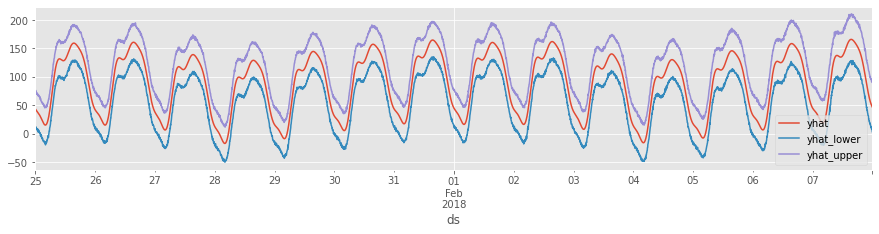

In [73]:
# Review the last 2 week prediction. 
column_name = ['yhat', 'yhat_lower', 'yhat_upper']
forecast.tail(12*24*7*2).plot(x='ds', y = column_name, grid=True, figsize=(15,3))
# forecast.plot(x='ds', y = column_name,figsize=(15,3))
plt.show()

As you can see, the prophet generate the prediction with boundaries. But sometime it went to negative values, which does not make sence. Thus more fine-turning are required if we want to employ this method. 

Prophet can detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible.

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


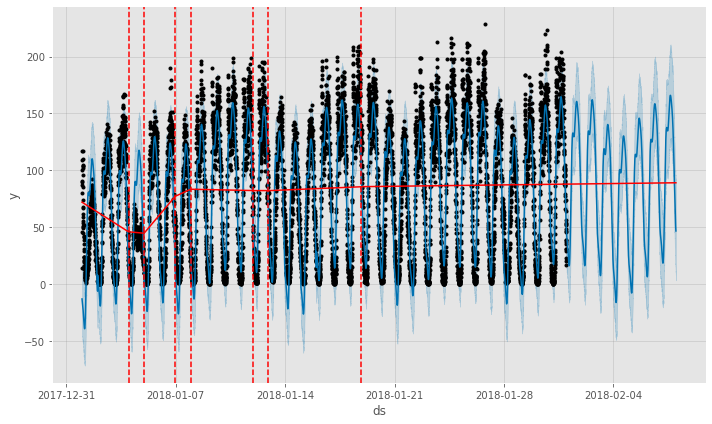

In [74]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


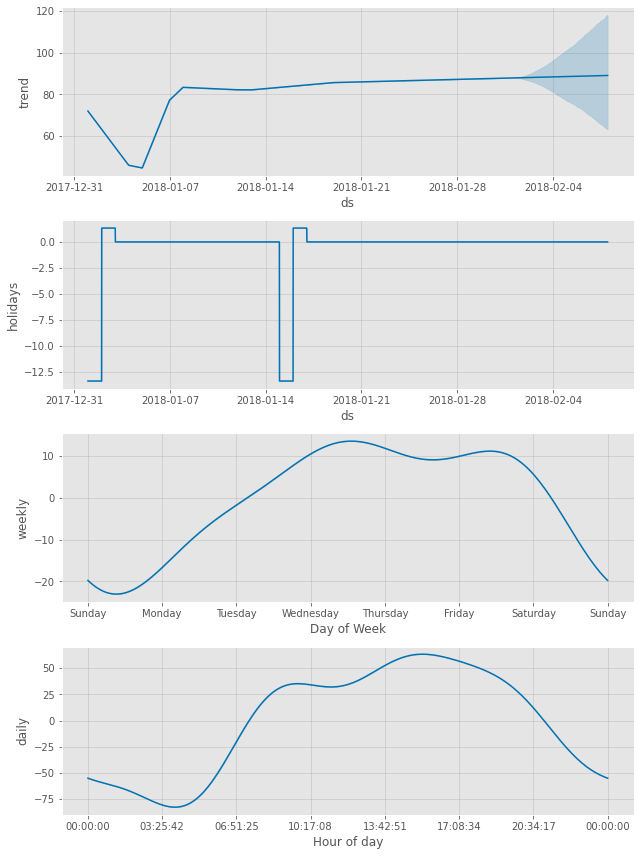

In [75]:
fig = m.plot_components(forecast)

We can **Save and load** the prophet model in JSON format

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


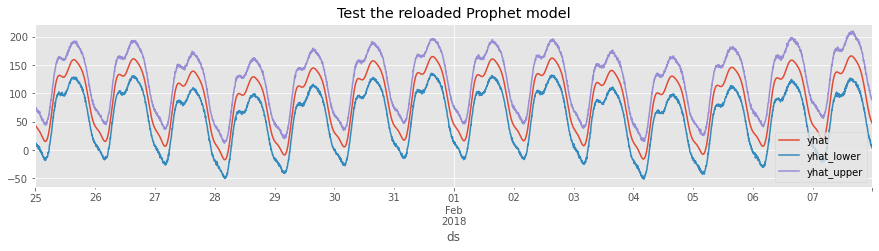

In [76]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('Prophet.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

with open('Prophet.json', 'r') as fin:
    m_from_json = model_from_json(json.load(fin))  # Load model
    
    
forecast = m_from_json.predict(future)
column_name = ['yhat', 'yhat_lower', 'yhat_upper']
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Review the last two week prediction. 
forecast.tail(12*24*7*2).plot(x='ds', y = column_name, grid=True, figsize=(15,3),title="Test the reloaded Prophet model")
# forecast.plot(x='ds', y = column_name,figsize=(15,3))
plt.show()

## 5 Review and Discussion <a class="anchor" id="5"></a>

Taxi Demand Forcasting can be seen as a predictive task related time and spacial locations.

In the above exploration, we mainly focused on the selected location and selected time range of the data.

The location are labelled with id with speficic boundary of regions. 

The simplest solution is to build indepnedent model of each region and then make prediction. This solution has its pros and cons. 

The good points:
- it is easy to maintain and operate the model in distributed manner. Each city/ coucil only needs to focusing on their own sub-system. 
- the model set are robust and can be used for different combinations to predict the total demand of larger ares. 
- the regionals pattern are easier to be identified. 

The trade-off are:
- there is no universal model / algorithm for the total demand prediction. 
- keep so many model co-exists may lead to extra cost on computational resources. 


### Next Step 

- Create a graph DB of Region as the standard input for modelling and analysis.\
    - For example, Upper Side East South (LocationID 236) is connected to Upper Side East North (LocationID 237)
    
```python
edge_dict = {"236": ["237", "43", "75", "263", "141"],
             "237": ["236", "141", "162", "163","43"],
            ... ... }
```

Thus, the new data set may look like the following:

In [77]:
df_236, df_237 = df_set[236], df_set[237]
df_236["d237"] = df_237['demand'] # add neighbour region demand as part of input.

# ... Keep add 236's neighour reigion demand as part of the input. 

df_236.tail() 

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,demand,day,hour,min,weekday,d237
tpep_pickup_datetime,,,,,,
2018-01-31 23:35:00,31.0,31,23,35,2,31.0
2018-01-31 23:40:00,29.0,31,23,40,2,29.0
2018-01-31 23:45:00,23.0,31,23,45,2,23.0
2018-01-31 23:50:00,17.0,31,23,50,2,17.0
2018-01-31 23:55:00,20.0,31,23,55,2,20.0



<img src="https://raw.githubusercontent.com/cuicaihao/aws_nyc_taxi_analysis/master/reports/Manhattan_Upper_East_Side.jpg" alt="Manhattan_Upper_East_Side" width="400"/>



- Join the various Taxi Demand data sets for each region.
- Use all the advanced graph models you can to build the region demand model. 
    - **Graph Neural Networks** can be good candidates for modelling. 
        - DeepWalk, node2vec, metapath2vec
        - GCN, GAT, GraphSAGE
        - ERNIESage, UniMP
    - **Deep pattern (Spectral/Spatial)** and insights can be found.


Seeing the data as graph lead to new modelling the demand based on the time and locations at the same time. 


## 6 References <a class="anchor" id="6"></a>

1. [2021 Machine Learning Lens - AWS Well-Architected Framework](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/welcome.html)

1. [AWS S3 Bucket: New York City Taxi and Limousine Commission (TLC) Trip Record Data](https://registry.opendata.aws/nyc-tlc-trip-records-pds/)

1. [2019 May: Exploring data with Python and Amazon S3 Select](https://github.com/aws-samples/cloud-experiments/tree/master/exploring-data)

1. [2017-April Build a Real-time Stream Processing Pipeline with Apache Flink on AWS](https://aws.amazon.com/blogs/big-data/build-a-real-time-stream-processing-pipeline-with-apache-flink-on-aws/)

1. [2021-Feb Architect and build the full machine learning lifecycle with AWS: An end-to-end Amazon SageMaker demo](https://aws.amazon.com/blogs/machine-learning/architect-and-build-the-full-machine-learning-lifecycle-with-amazon-sagemaker/)

1. [2021-Feb Machine learning on distributed Dask using Amazon SageMaker and AWS Fargate](https://aws.amazon.com/blogs/machine-learning/machine-learning-on-distributed-dask-using-amazon-sagemaker-and-aws-fargate/)

1. [2018 Analyze the NYC Taxi Data by Chih-Ling Hsu](https://chih-ling-hsu.github.io/2018/05/14/NYC)


## The END  <a class="anchor" id="7"></a>

DISCLAIMER:

- The python scripts in this notebook can be released under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/), which gives permission to use the content for almost any purpose (but does not grant any trademark permissions).
- This content does not represent the author's company or any associated business, clients and services.
- The author does not accept liability for any errors or omissions caused by using the contents of this notebook.
- The GitHub repo is [here](https://github.com/cuicaihao/aws_nyc_taxi_analysis), author may update the notebook to add new features fix typos.
